In [1]:
%matplotlib inline
import itertools
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn import svm
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, log_loss
from sklearn.utils import shuffle

from keras.utils import to_categorical
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

from IPython.display import display

/root/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def make_2d_dataset(centers, cluster_std):
    n_features = 2
    n_centers = len(centers)
    X, y = make_blobs(n_samples=500*n_centers,
                      n_features=n_features,
                      centers=centers,
                      cluster_std=cluster_std,
                      shuffle=False,
                      random_state=0)

    input_keys = ['input' + str(i) for i in range(n_features)]
    output_key = 'class'
    dummy_key = 'miss'
    df = pd.DataFrame(data=X, columns=input_keys)
    df[output_key] = y
    df[dummy_key] = False
    
    df.sort_values(by=output_key, inplace=True)
    
    return df, input_keys, output_key, dummy_key


def make_predict_df(df, classifier, input_keys, output_key):
    if len(input_keys) != 2:
        raise Exception('Error: Check len(input_keys)')
    
    # ----- visualize predict results -----
    # prepairt of making input data
    x0 = df[input_keys[0]]
    x1 = df[input_keys[1]]
    x0_min, x0_max = x0.min(), x0.max()
    x1_min, x1_max = x1.min(), x1.max()
    
    # make mesh data
    x0_mesh, x1_mesh = np.meshgrid(np.linspace(x0_min, x0_max, 100),
                                   np.linspace(x1_min, x1_max, 100))
    X = np.array([x0_mesh.ravel(), x1_mesh.ravel()]).T
    
    # predict
    y = classifier.predict(X)
    
    # make df
    df_predict = pd.DataFrame(columns=input_keys, data=X)
    df_predict[output_key] = y
    df_predict.sort_values(by=output_key, inplace=True)
    
    return df_predict


def visualize(df_raw, df_predict, input_keys, output_key, title):
    # ----- set constants -----
    color_list = ["r", "g", "b", "c", "m", "y", "k", "w"]
    class_list = pd.concat([df_raw[output_key], df_predict[output_key]])
    class_list = list(set(class_list))
    class_list.sort()

    # ----- check constants -----
    if len(input_keys) != 2:
        raise Exception('Error: Check len(input_keys)')

    if len(class_list) > len(color_list):
        raise Exception('Error: Check len(class_list)')
    
    # ----- visualize predict results -----
    for i, class_i in enumerate(class_list):
        df_i = df_predict[df_predict[output_key] == class_i]
        plt.scatter(x=input_keys[0], y=input_keys[1], data=df_i, alpha=0.03, c=color_list[i], label='predict_class '+ str(i))
    
    # ----- visualize labbeled data -----
    for i, class_i in enumerate(class_list):
        df_i = df_raw[df_raw[output_key] == class_i]
        plt.scatter(x=input_keys[0], y=input_keys[1], data=df_i, c=color_list[i], s=3, label='data_class '+ str(i))
    
    # ----- set legend and title -----    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')   
    plt.title(title)
    plt.show()
    
    return None


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


def hist_loss(loss_all, miss):
    right_loss = loss_all[miss == False]
    wrong_loss = loss_all[miss == True]

    label=['right label data - '+str(len(right_loss)), 'wrong label data - '+str(len(wrong_loss))]
    plt.hist([right_loss, wrong_loss], bins=10, color=['b','r'], label=label)

    plt.legend()
    plt.xlabel('loss')
    plt.show()

    return None


def analize(df, input_keys, output_key, dummy_key, title):
    class_list = list(set(df[output_key]))
    class_list.sort()

    # predict
    classifier = svm.SVC(probability=True)
    classifier.fit(df[input_keys], df[output_key])

    y_pred = classifier.predict(df[input_keys])
    Y_proba = classifier.predict_proba(df[input_keys])
    Y_log_proba = classifier.predict_log_proba(df[input_keys])

    # visualize
    df_predict = make_predict_df(df, classifier, input_keys, output_key)
    visualize(df, df_predict, input_keys, output_key, title)

    # calc metrics
    y_true = df[output_key]
    recall = recall_score(y_true=y_true, y_pred=y_pred, labels=class_list, average=None)
    precision = precision_score(y_true=y_true, y_pred=y_pred, labels=class_list, average=None)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, labels=class_list, average=None) 

    result = pd.DataFrame()
    result['recall'] = recall
    result['precision'] = precision
    result['f1_score'] = f1
    display(result)
    
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=class_list)
    plot_confusion_matrix(cm, class_list)
    
    # check miss labeld data
    loss = np.sum(-np.eye(len(class_list))[y_true] * np.log(Y_proba), axis=1)
    miss = (df[dummy_key] == True)

    hist_loss(loss, miss)
    
    return None


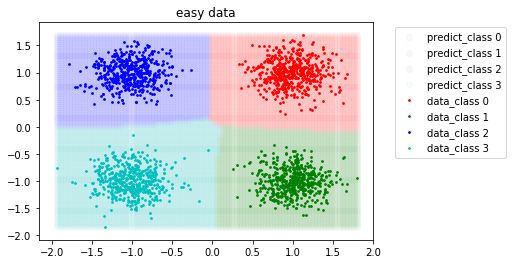

,recall,precision,f1_score
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0


Confusion matrix, without normalization


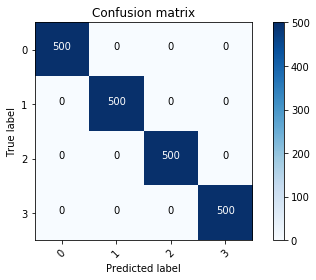

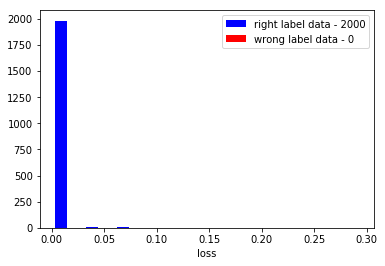

分類が簡単なデータ分布なので、recallとprecisionはともに高い。
lossもほとんどのデータで小さな値。


In [3]:
centers = np.array([[ 1, 1],
                    [ 1,-1],
                    [-1, 1],
                    [-1,-1]])
df_easy, input_keys, output_key, dummy_key = make_2d_dataset(centers=centers, cluster_std=0.25)
analize(df_easy, input_keys, output_key, dummy_key, 'easy data')

print('分類が簡単なデータ分布なので、recallとprecisionはともに高い。')
print('lossもほとんどのデータで小さな値。')

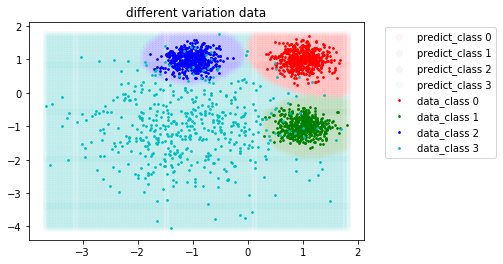

,recall,precision,f1_score
0,1.000,0.988142,0.994036
1,0.996,0.961390,0.978389
2,1.000,0.945180,0.971817
3,0.890,0.995526,0.939810


Confusion matrix, without normalization


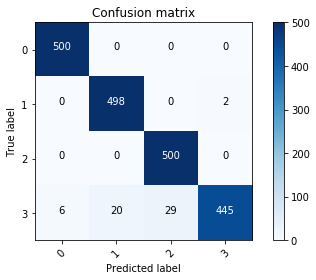

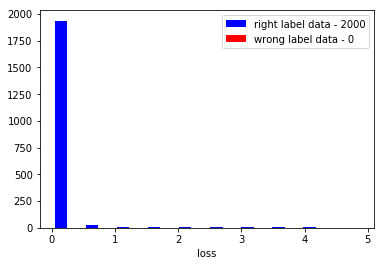

一部のクラス(class3)のみ特徴量のクラス内分散が大きい例。
例えば掘削作業は他作業に比べてバリエーションがある(≒クラス内分散が大きい)かも。
class3のデータは全体的に広がっており、ラベルミスというよりもバリエーションあると考えるのが自然？
class3のようなデータは、recall < precisionとなる傾向がある。
このような場合は、class3およびその隣接しているclassの分類は難しいので、特徴量の再検討が必要。


In [4]:
# バリエーションが少ないクラス
centers = np.array([[ 1, 1],
                    [ 1,-1],
                    [-1, 1]])
df_small_variation, input_keys, output_key, dummy_key = make_2d_dataset(centers=centers, cluster_std=0.25)
# バリエーションが多いクラス
centers = np.array([[-1,-1]])
df_large_variation, input_keys, output_key, dummy_key = make_2d_dataset(centers=centers, cluster_std=1)
df_large_variation[output_key] = 3
# 両者が混ざったデータ
df_different_variation = pd.concat([df_small_variation, df_large_variation])
# 解析と結果表示
analize(df_different_variation, input_keys, output_key, dummy_key, 'different variation data')

print('一部のクラス(class3)のみ特徴量のクラス内分散が大きい例。')
print('例えば掘削作業は他作業に比べてバリエーションがある(≒クラス内分散が大きい)かも。')
print('class3のデータは全体的に広がっており、ラベルミスというよりもバリエーションあると考えるのが自然？')
print('class3のようなデータは、recall < precisionとなる傾向がある。')
print('このような場合は、class3およびその隣接しているclassの分類は難しいので、特徴量の再検討が必要。')

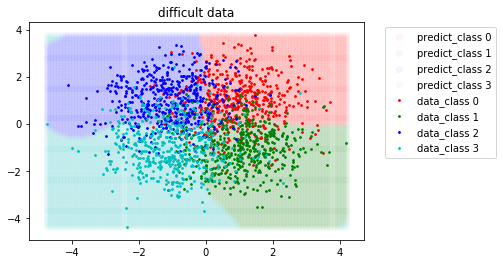

,recall,precision,f1_score
0,0.724,0.712598,0.718254
1,0.736,0.749491,0.742684
2,0.754,0.700743,0.726397
3,0.690,0.745140,0.716511


Confusion matrix, without normalization


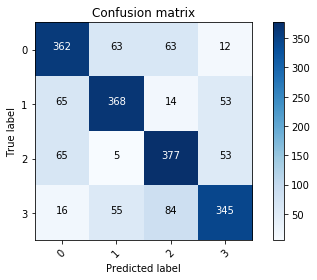

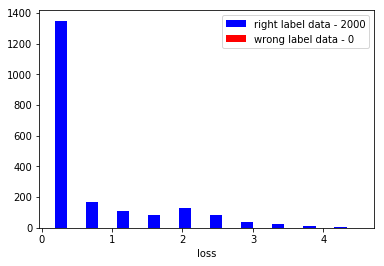

全クラスとも特徴空間でバリエーションがある場合は、やはり分類が難しい。
recallとprecisionは同程度の値になる。
lossが大きなデータも多々ある。


In [5]:
centers = np.array([[ 1, 1],
                    [ 1,-1],
                    [-1, 1],
                    [-1,-1]])
df_large_variation, input_keys, output_key, dummy_key = make_2d_dataset(centers=centers, cluster_std=1)
analize(df_large_variation, input_keys, output_key, dummy_key, 'difficult data')

print('全クラスとも特徴空間でバリエーションがある場合は、やはり分類が難しい。')
print('recallとprecisionは同程度の値になる。')
print('lossが大きなデータも多々ある。')

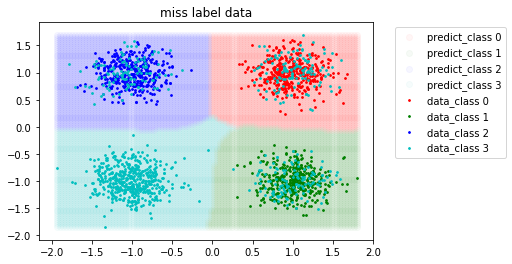

,recall,precision,f1_score
0,1.000000,0.742,0.851894
1,1.000000,0.746,0.854525
2,1.000000,0.770,0.870056
3,0.574053,1.000,0.729395


Confusion matrix, without normalization


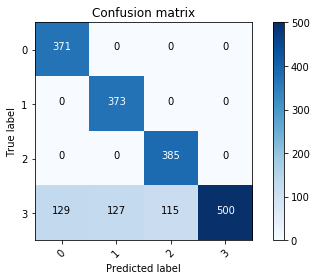

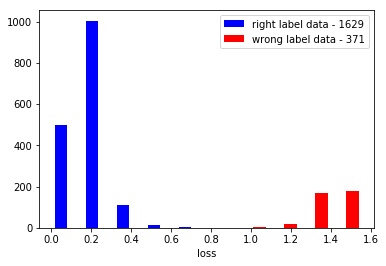

恣意的にラベルミスを起こしたため、本来class0とラベル付するべきデータがclass3になっている。
このような場合は、class0はrecall > precisionとなる。
逆にrecall > precisionとなるclassがあれば、ラベルミスの間違いを疑うトリガーとなるかも？
また、ラベルが間違っているデータはlossの値も大きくなる。


In [6]:
centers = np.array([[ 1, 1],
                    [ 1,-1],
                    [-1, 1],
                    [-1,-1]])
df_original, input_keys, output_key, dummy_key = make_2d_dataset(centers=centers, cluster_std=0.25)

df_original = df_original.sample(frac=1).reset_index()
df_mistake = df_original.copy()
n_mistake = round(0.25 * len(df_mistake))
df_mistake.loc[:n_mistake, output_key] = 3

miss = df_mistake[output_key].values != df_original[output_key].values
df_mistake.loc[miss, dummy_key] = True

df_mistake.sort_values(by=output_key, inplace=True)
analize(df_mistake, input_keys, output_key, dummy_key, 'miss label data')

print('恣意的にラベルミスを起こしたため、本来class0とラベル付するべきデータがclass3になっている。')
print('このような場合は、class0はrecall > precisionとなる。')
print('逆にrecall > precisionとなるclassがあれば、ラベルミスの間違いを疑うトリガーとなるかも？')
print('また、ラベルが間違っているデータはlossの値も大きくなる。')

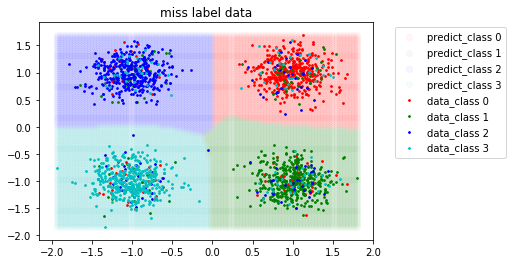

,recall,precision,f1_score
0,0.794872,0.806000,0.800397
1,0.798793,0.792415,0.795591
2,0.811741,0.802000,0.806841
3,0.816733,0.821643,0.819181


Confusion matrix, without normalization


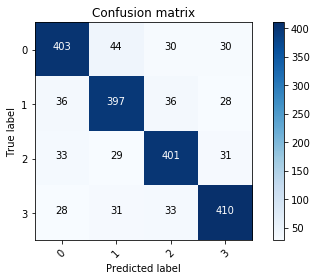

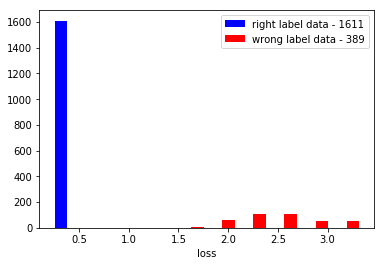

先程の例とは違い、クラスに偏りなくラベル間違いを発生させた
この場合は、recall > precisionではなく、recall ≒ precisionとなる
しかし、ラベルが間違っているデータはlossの値も大きくなる。


In [7]:
centers = np.array([[ 1, 1],
                    [ 1,-1],
                    [-1, 1],
                    [-1,-1]])
df_original, input_keys, output_key, dummy_key = make_2d_dataset(centers=centers, cluster_std=0.25)

df_original = df_original.sample(frac=1).reset_index()
df_mistake = df_original.copy()
n_mistake = round(0.25 * len(df_mistake))
df_mistake.loc[:n_mistake, output_key] = np.random.randint(0, 4, n_mistake+1)

miss = df_mistake[output_key].values != df_original[output_key].values
df_mistake.loc[miss, dummy_key] = True

df_mistake.sort_values(by=output_key, inplace=True)
analize(df_mistake, input_keys, output_key, dummy_key, 'miss label data')

print('先程の例とは違い、クラスに偏りなくラベル間違いを発生させた')
print('この場合は、recall > precisionではなく、recall ≒ precisionとなる')
print('しかし、ラベルが間違っているデータはlossの値も大きくなる。')

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 4s 68us/step - loss: 0.2807 - acc: 0.9189 - val_loss: 0.1356 - val_acc: 0.9582
Epoch 2/3
60000/60000 [==============================] - 6s 106us/step - loss: 0.0973 - acc: 0.9708 - val_loss: 0.0902 - val_acc: 0.9726
Epoch 3/3
60000/60000 [==============================] - 6s 95us/step - loss: 0.0628 - acc: 0.9810 - val_loss: 0.0704 - val_acc: 0.9789


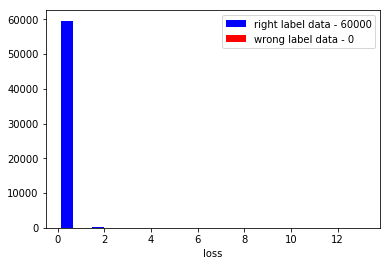

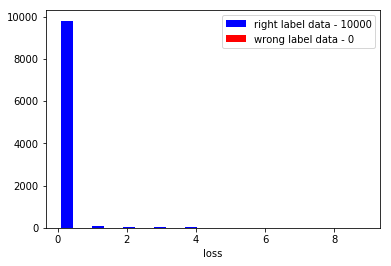

MNISTデータをそのまま利用する場合は、lossが大きなデータは少ない。


In [8]:
# MINIST

# make data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255
X_test  = X_test  / 255
Y_train = to_categorical(y_train, num_classes=10)
Y_test  = to_categorical(y_test,  num_classes=10)

# define and train model
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=10,  activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=256, epochs=3, validation_data=(X_test, Y_test))

# predict
Y_train_pred = model.predict(X_train)
Y_test_pred  = model.predict(X_test)
loss_train = -np.sum(Y_train * np.log(Y_train_pred), axis=1)
loss_test  = -np.sum(Y_test *  np.log(Y_test_pred),  axis=1)
miss_train = np.array([False for i in loss_train])
miss_test  = np.array([False for i in loss_test])

# show result
hist_loss(loss_train, miss_train)
hist_loss(loss_test,  miss_test)

print('MNISTデータをそのまま利用する場合は、lossが大きなデータは少ない。')

In [9]:
# make data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255
X_test  = X_test  / 255

shuffle(X_train, y_train, replace=True)
shuffle(X_test,  y_test,  replace=True)

y_train_miss = y_train.copy()
y_test_miss  = y_test.copy()

n_shuffle_train = round(0.2 * len(y_train))
n_shuffle_test  = round(0.2 * len(y_test))
y_train_miss[:n_shuffle_train] = shuffle(y_train[:n_shuffle_train])
y_test_miss[:n_shuffle_test]   = shuffle(y_test[:n_shuffle_test])
miss_train = (y_train_miss != y_train)
miss_test  = (y_test_miss  != y_test)

Y_train_miss = to_categorical(y_train_miss, num_classes=10)
Y_test_miss  = to_categorical(y_test_miss,  num_classes=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 9s 147us/step - loss: 1.1195 - acc: 0.7504 - val_loss: 0.9942 - val_acc: 0.7881
Epoch 2/3
60000/60000 [==============================] - 8s 130us/step - loss: 0.9737 - acc: 0.7911 - val_loss: 0.9795 - val_acc: 0.7944
Epoch 3/3
60000/60000 [==============================] - 6s 100us/step - loss: 0.9278 - acc: 0.8003 - val_loss: 0.9824 - val_acc: 0.7967


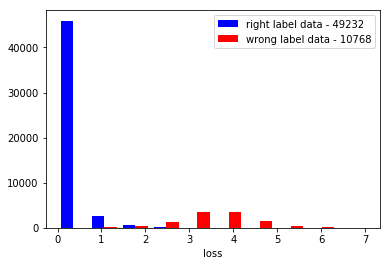

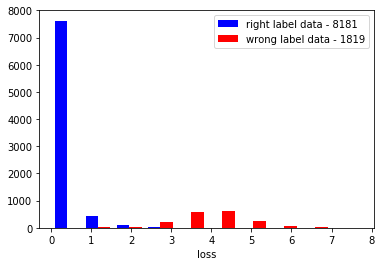

MNISTデータの2割程度をランダムにラベルづけした場合のlossを示す。
lossが大きなデータがラベル間違いをしていることがわかる。
偏りがない乱数という強い仮定の元であるが、lossの大きさでラベルミスを見つけられる可能性を示せた。


In [10]:
# define and train model
model = Sequential()
model.add(Flatten(input_shape=X_train.shape[1:]))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=10,  activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.fit(X_train, Y_train_miss, batch_size=256, epochs=3, validation_data=(X_test, Y_test_miss))

# predict
Y_train_pred = model.predict(X_train)
Y_test_pred  = model.predict(X_test)
loss_train = -np.sum(Y_train_miss * np.log(Y_train_pred), axis=1)
loss_test  = -np.sum(Y_test_miss  * np.log(Y_test_pred),  axis=1)

# show result
hist_loss(loss_train, miss_train)
hist_loss(loss_test,  miss_test)

print('MNISTデータの2割程度をランダムにラベルづけした場合のlossを示す。')
print('lossが大きなデータがラベル間違いをしていることがわかる。')
print('偏りがない乱数という強い仮定の元であるが、lossの大きさでラベルミスを見つけられる可能性を示せた。')